# Augmentation

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


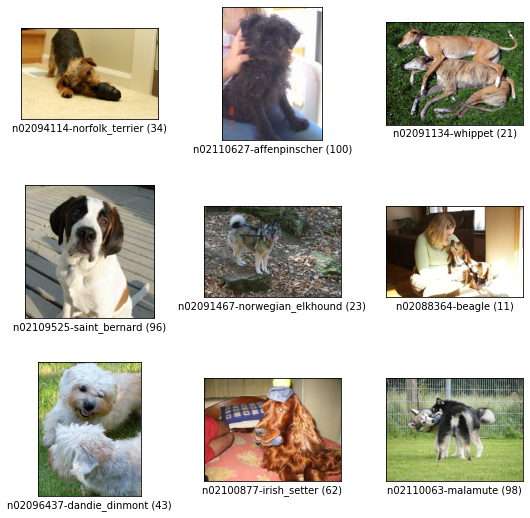

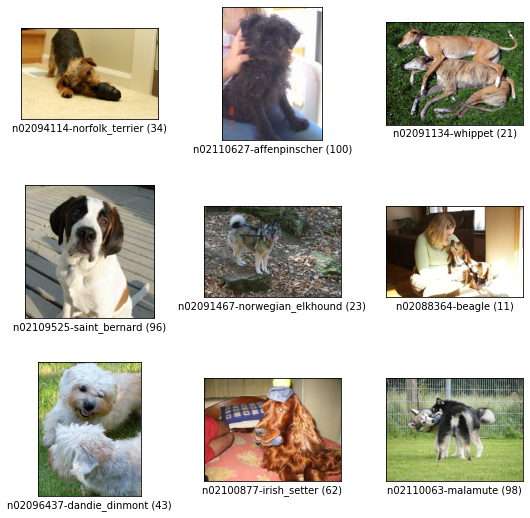

In [4]:
tfds.show_examples(ds_train, ds_info)

In [5]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:

RandomRotation(1./16)
RandomZoom(0.1)
RandomContrast(0.01)
RandomTranslation(0.1,0.1)

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [7]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

### Cutmix

In [8]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [9]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [10]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_size_x=224, image_size_y=224, num_classes=120):
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [11]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max,image_a.shape[1],image_a.shape[0]))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### Mixup

In [12]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [13]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [14]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [15]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [16]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [17]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [18]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [19]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [20]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 196s 201ms/step - loss: 2.1945 - accuracy: 0.4555 - val_loss: 3.4257 - val_accuracy: 0.2000
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 0.6922 - accuracy: 0.8102 - val_loss: 1.0984 - val_accuracy: 0.6790
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 0.2057 - accuracy: 0.9595 - val_loss: 0.9588 - val_accuracy: 0.7188
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0638 - accuracy: 0.9945 - val_loss: 0.9235 - val_accuracy: 0.7317
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0295 - accuracy: 0.9984 - val_loss: 0.9171 - val_accuracy: 0.7383
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0179 - accuracy: 0.9994 - val_loss: 0.9265 - val_accuracy: 0.7420
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0127 - accuracy: 0.9997 - val_loss: 0.9444 -

In [21]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 160s 205ms/step - loss: 2.2528 - accuracy: 0.4326 - val_loss: 2.8963 - val_accuracy: 0.2823
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 0.9300 - accuracy: 0.7315 - val_loss: 1.2182 - val_accuracy: 0.6437
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 0.4809 - accuracy: 0.8681 - val_loss: 1.0958 - val_accuracy: 0.6771
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 0.2526 - accuracy: 0.9436 - val_loss: 0.9820 - val_accuracy: 0.7170
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 0.1421 - accuracy: 0.9718 - val_loss: 1.0059 - val_accuracy: 0.7125
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0851 - accuracy: 0.9870 - val_loss: 1.0018 - val_accuracy: 0.7201
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0525 - accuracy: 0.9929 - val_loss: 0.9800 -

In [22]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 163s 206ms/step - loss: 3.8802 - accuracy: 0.1931 - val_loss: 3.3720 - val_accuracy: 0.2142
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 3.0351 - accuracy: 0.4117 - val_loss: 1.6810 - val_accuracy: 0.5454
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 2.7601 - accuracy: 0.4921 - val_loss: 1.3957 - val_accuracy: 0.6170
Epoch 4/20
750/750 [==============================] - 154s 206ms/step - loss: 2.5849 - accuracy: 0.5423 - val_loss: 1.2839 - val_accuracy: 0.6536
Epoch 5/20
750/750 [==============================] - 154s 206ms/step - loss: 2.4482 - accuracy: 0.5847 - val_loss: 1.1519 - val_accuracy: 0.6831
Epoch 6/20
750/750 [==============================] - 154s 206ms/step - loss: 2.3293 - accuracy: 0.6210 - val_loss: 1.1766 - val_accuracy: 0.6705
Epoch 7/20
750/750 [==============================] - 154s 206ms/step - loss: 2.2535 - accuracy: 0.6431 - val_loss: 1.2904 -

In [23]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 162s 207ms/step - loss: 3.7614 - accuracy: 0.2239 - val_loss: 3.8485 - val_accuracy: 0.1355
Epoch 2/20
750/750 [==============================] - 154s 206ms/step - loss: 2.9472 - accuracy: 0.4494 - val_loss: 1.4876 - val_accuracy: 0.5802
Epoch 3/20
750/750 [==============================] - 154s 206ms/step - loss: 2.6920 - accuracy: 0.5340 - val_loss: 1.3645 - val_accuracy: 0.6126
Epoch 4/20
750/750 [==============================] - 154s 206ms/step - loss: 2.5127 - accuracy: 0.6057 - val_loss: 1.5154 - val_accuracy: 0.5869
Epoch 5/20
750/750 [==============================] - 154s 206ms/step - loss: 2.4116 - accuracy: 0.6473 - val_loss: 1.1501 - val_accuracy: 0.6734
Epoch 6/20
750/750 [==============================] - 154s 206ms/step - loss: 2.2959 - accuracy: 0.6859 - val_loss: 1.3723 - val_accuracy: 0.6212
Epoch 7/20
750/750 [==============================] - 154s 206ms/step - loss: 2.2099 - accuracy: 0.7225 - val_loss: 1.1565 -

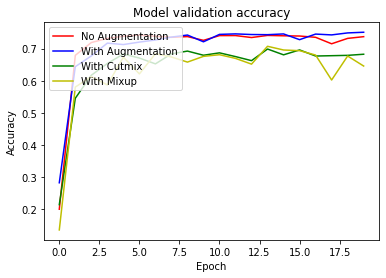

In [24]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')
plt.show()

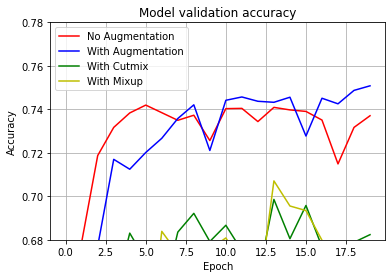

In [25]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.68, 0.78)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
plt.show()